# Example of grouped regressions

In this section, we want to demanstrate a slightly advanced example for using Pandas grouped transformation for performing many ordinary least square model fits in parallel. We reuse the weather data and try to predict the temperature of all stations with a very simple model per station.

In [14]:
import pandas as pd

import pyspark.sql
import pyspark.sql.functions as f

from pyspark.sql.types import *
from pyspark.sql import SparkSession

if not 'spark' in locals():
    spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory","24G") \
        .getOrCreate()

spark

In [2]:
spark.conf.set("spark.sql.adaptive.enabled", False)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [3]:
%matplotlib inline

## 1 Load Data
First we load data of a single year.

In [4]:
storageLocation = "s3://dimajix-training/data/weather"

In [5]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

rawWeatherData = spark.read.text(storageLocation + "/2003")
weather_all = rawWeatherData.select(
    substring(col("value"),5,6).alias("usaf"),
    substring(col("value"),11,5).alias("wban"),
    to_timestamp(substring(col("value"),16,12),"yyyyMMddHHmm").alias("timestamp"),
    to_timestamp(substring(col("value"),16,12),"yyyyMMddHHmm").cast("long").alias("ts"),
    substring(col("value"),42,5).alias("report_type"),
    substring(col("value"),61,3).alias("wind_direction"),
    substring(col("value"),64,1).alias("wind_direction_qual"),
    substring(col("value"),65,1).alias("wind_observation"),
    (substring(col("value"),66,4).cast("float") / lit(10.0)).alias("wind_speed"),
    substring(col("value"),70,1).alias("wind_speed_qual"),
    (substring(col("value"),88,5).cast("float") / lit(10.0)).alias("air_temperature"),
    substring(col("value"),93,1).alias("air_temperature_qual")
)

# 2 Analysis of one station

First we only analyse a single station, just to check our approach and the expressiveness of our model. It won't be a very good fit, but it will be good enough for our needs to demonstrate the concept.

So first we pick a single station, and we also only keep those records with a valid temeprature measurement.

In [6]:
weather_single = weather_all.where("usaf='954920' and wban='99999'").cache()

In [8]:
pdf = weather_single.where(weather_single.air_temperature_qual == 1).toPandas()
pdf[0:10]

,usaf,wban,timestamp,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual
0,954920,99999,2003-01-01 00:00:00,1041379200,FM-12,200,1,N,4.6,1,25.6,1
1,954920,99999,2003-01-01 02:00:00,1041386400,FM-12,230,1,N,5.7,1,27.8,1
2,954920,99999,2003-01-01 03:00:00,1041390000,FM-12,220,1,N,7.7,1,29.6,1
3,954920,99999,2003-01-01 05:00:00,1041397200,FM-12,230,1,N,6.2,1,29.7,1
4,954920,99999,2003-01-01 06:00:00,1041400800,FM-12,240,1,N,6.7,1,30.2,1
5,954920,99999,2003-01-01 08:00:00,1041408000,FM-12,210,1,N,6.7,1,29.1,1
6,954920,99999,2003-01-01 09:00:00,1041411600,FM-12,220,1,N,5.7,1,28.0,1
7,954920,99999,2003-01-01 11:00:00,1041418800,FM-12,210,1,N,3.6,1,25.9,1
8,954920,99999,2003-01-01 12:00:00,1041422400,FM-12,200,1,N,4.1,1,25.0,1
9,954920,99999,2003-01-01 14:00:00,1041429600,FM-12,190,1,N,6.2,1,23.0,1


## 2.1 Create Feature Space

Our model will simply predict the temperature depending on the time and day of year. We use sin and cos of with a day-wide period and a year-wide period as features for fitting the model.

<AxesSubplot:xlabel='timestamp'>

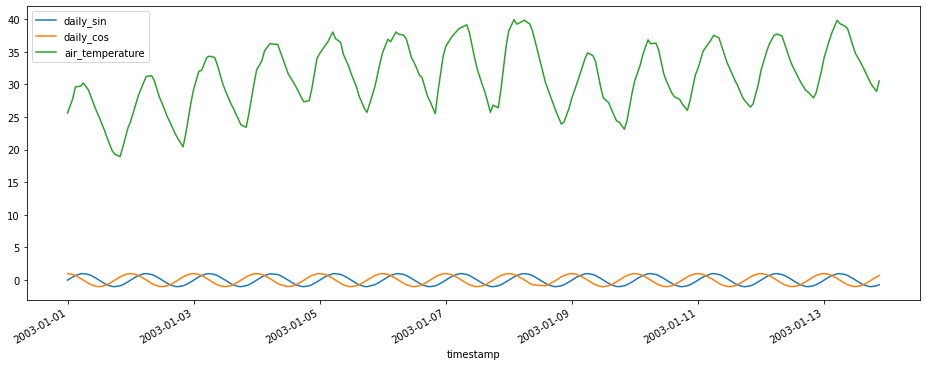

In [9]:
import numpy as np
import math

seconds_per_day = 24*60*60
seconds_per_year = 365*seconds_per_day

# Add sin and cos as features for fitting
pdf['daily_sin'] = np.sin(pdf['ts']/seconds_per_day*2.0*math.pi)
pdf['daily_cos'] = np.cos(pdf['ts']/seconds_per_day*2.0*math.pi)
pdf['yearly_sin'] = np.sin(pdf['ts']/seconds_per_year*2.0*math.pi)
pdf['yearly_cos'] = np.cos(pdf['ts']/seconds_per_year*2.0*math.pi)

# Make a plot, just to check how it looks like
pdf[0:200].plot(x='timestamp', y=['daily_sin','daily_cos','air_temperature'], figsize=[16,6])

## 2.2 Fit model

Now that we have the temperature and some features, we fit a simple model.

<AxesSubplot:xlabel='timestamp'>

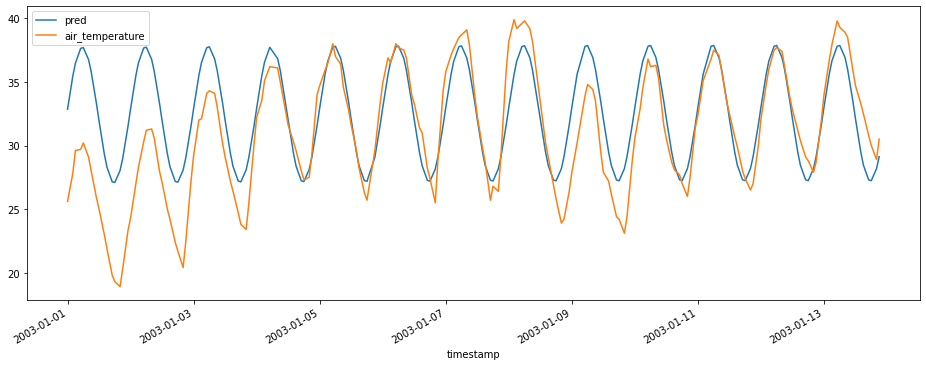

In [10]:
import statsmodels.api as sm

# define target variable y
y = pdf['air_temperature']
# define feature variables X
X = pdf[['ts', 'daily_sin', 'daily_cos', 'yearly_sin', 'yearly_cos']]
X = sm.add_constant(X)
# fit model
model = sm.OLS(y, X).fit()

# perform prediction
pdf['pred'] = model.predict(X)

# Make a plot of real temperature vs predicted temperature
pdf[0:200].plot(x='timestamp', y=['pred','air_temperature'], figsize=[16,6])

## 2.3 Inspect Model

Now let us inspect the model, in order to find a way to store it in a Pandas DataFrame

In [11]:
model.params

const         1.836431e+01
ts            4.503481e-09
daily_sin     5.313380e+00
daily_cos     4.699659e-01
yearly_sin    3.045510e+00
yearly_cos    8.993267e+00
dtype: float64

In [12]:
type(model.params)

pandas.core.series.Series

Finally let us create a Pandas DataFrame from the model parameters. This code snippet will be needed later when we want to parallelize the fitting for different weather stations using Spark.

In [15]:
x_columns = X.columns
pd.DataFrame([[model.params[i] for i in  x_columns]], columns=x_columns)

,const,ts,daily_sin,daily_cos,yearly_sin,yearly_cos
0,18.364309,4.503481e-09,5.31338,0.469966,3.04551,8.993267


# 3 Perform OLS for all stations

Now we want to create a model for all stations. First we filter the data again, such that we only have valid temperature measurements.

In [16]:
valid_weather = weather_all.filter(weather_all.air_temperature_qual == 1)

## 3.1 Feature extraction

Now we generate the same features, but this time we use Spark instead of Pandas operations. This simplifies later model fitting.

In [17]:
import math

seconds_per_day = 24*60*60
seconds_per_year = 365*seconds_per_day

features = valid_weather.select(
    valid_weather.usaf,
    valid_weather.wban,
    valid_weather.air_temperature,
    valid_weather.ts,
    lit(1.0).alias('const'),
    sin(valid_weather.ts * 2.0 * math.pi / seconds_per_day).alias('daily_sin'),
    cos(valid_weather.ts * 2.0 * math.pi / seconds_per_day).alias('daily_cos'),
    sin(valid_weather.ts * 2.0 * math.pi / seconds_per_year).alias('yearly_sin'),
    cos(valid_weather.ts * 2.0 * math.pi / seconds_per_year).alias('yearly_cos')
)

features.limit(10).toPandas()

,usaf,wban,air_temperature,ts,const,daily_sin,daily_cos,yearly_sin,yearly_cos
0,703160,25624,-2.0,1041380220,1.0,0.074108,0.997250,0.137480,0.990505
1,703160,25624,2.0,1041400380,1.0,0.999534,0.030539,0.141457,0.989944
2,703160,25624,-3.0,1041421980,1.0,0.030539,-0.999534,0.145716,0.989326
3,703160,25624,-4.0,1041443580,1.0,-0.999534,-0.030539,0.149973,0.988690
4,703160,25624,-3.0,1041465180,1.0,-0.030539,0.999534,0.154226,0.988036
5,703160,25624,-2.0,1041486780,1.0,0.999534,0.030539,0.158477,0.987363
6,703160,25624,-2.0,1041489960,1.0,0.979925,-0.199368,0.159102,0.987262
7,703160,25624,-2.0,1041490920,1.0,0.963630,-0.267238,0.159291,0.987232
8,703160,25624,-2.0,1041499380,1.0,0.632705,-0.774393,0.160955,0.986962
9,703160,25624,-2.0,1041501960,1.0,0.477159,-0.878817,0.161462,0.986879


## 3.2 Fit Models

Now we use a Spark Pandas grouped UDF in order to fit models for all weather stations in parallel. This is done by defining a Pandas Gruped Map UDF, which receives all values of a single weather station as its input and returns a Pandas data frame containing one row with all model parameters. This UDF is then used in a grouped map aggregation using `groupby(...).apply(...)`.

In [20]:
group_columns = ['usaf', 'wban']
y_column = 'air_temperature'
x_columns = ['ts', 'const', 'daily_sin', 'daily_cos', 'yearly_sin', 'yearly_cos']
schema = features.select(*group_columns, *x_columns).schema

def ols(pdf):
    # Extract grouping information from appropriate columns
    group = [pdf[g].iloc[0] for g in group_columns]
    # Extract target variable
    y = pdf[y_column]
    # Extract predictor variables
    X = pdf[x_columns]
    # Create model using Python statsmodel package to fit y to input variables x
    model = sm.OLS(y, X).fit()
    # Create a Pandas data frame with one row containing the grouping columns and all model parameters
    return pd.DataFrame([group + [model.params[i] for i in x_columns]], columns=group_columns + x_columns)

# Now fit model for all weather stations in parallel using Spark
models = features.groupby(weather_all.usaf, weather_all.wban).applyInPandas(ols, schema).cache()

In [21]:
models.limit(10).toPandas()

,usaf,wban,ts,const,daily_sin,daily_cos,yearly_sin,yearly_cos
0,954920,99999,0,18.364309,5.313380,0.469966,3.045510,8.993267
1,038940,99999,0,25.272246,-0.826144,-1.376067,-3.693573,-4.713150
2,999999,94074,0,-5.866619,-4.867254,4.548186,-2.788635,-13.403601
3,111200,99999,0,-73.725936,-2.577125,-3.810438,-3.091114,-11.116201
4,727923,94225,0,178.539020,-0.597472,1.318946,-5.304252,-2.788685
5,701330,26616,0,207.711918,0.154068,0.326450,-9.337710,-11.273081
6,724273,03804,0,-138.120951,-1.752578,1.236404,-4.714701,-10.270727
7,726410,14837,0,-88.717287,-1.930264,2.198496,-6.594899,-11.926900
8,725560,14941,0,21.283986,-2.378156,3.185683,-5.713081,-13.298528
9,028450,99999,0,-188.638633,-0.772881,-1.636365,-3.677941,-12.949335


## 3.3 Inspect and compare results

Now let's pick the same station again, and compare the model to the original model.

In [22]:
models.where("usaf='954920' and wban='99999'").toPandas()

,usaf,wban,ts,const,daily_sin,daily_cos,yearly_sin,yearly_cos
0,954920,99999,0,18.364309,5.31338,0.469966,3.04551,8.993267


In [23]:
model.params

const         1.836431e+01
ts            4.503481e-09
daily_sin     5.313380e+00
daily_cos     4.699659e-01
yearly_sin    3.045510e+00
yearly_cos    8.993267e+00
dtype: float64